<a href="https://colab.research.google.com/github/tuananht/image-text/blob/master/Image_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please read [tesseract](https://pypi.org/project/pytesseract/) to overview.

For more type in pytesseract, read [here](https://github.com/madmaze/pytesseract/blob/master/src/pytesseract.py).

[Scanning Image with Python](https://medium.com/@eman.diab5010/scanning-images-with-python-d9b46f3ba484)

[Four point invoice transform](https://github.com/KMKnation/Four-Point-Invoice-Transform-with-OpenCV)

If you want to detect Vietnamese, please install `tessaract-ocr-vie`. Visit [here](https://github.com/tesseract-ocr/tessdata) or [here](https://tesseract-ocr.github.io/tessdoc/Data-Files#data-files-for-version-400-november-29-2016) to explorer the language data in Tesseract 4.0.0


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!sudo apt-get install tesseract-ocr-vie

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 12 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,361 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2
import os
from skimage.filters import threshold_local
import numpy as np
import imutils

import pytesseract

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_name = "/content/drive/My Drive/UIT-GRAD/HK1/CS2225.CH1501.N013/Image/20201108_173848.jpg"
img = cv2.imread(file_name)
# cv2_imshow(img)

In [ ]:
def imageToData(originalImage, image, language = 'vie'):
  # immage_to_data will return object with:
  # level, page_num, block_num, par_num, line_num, word_num
  # top, left, width, height, conf, text
  data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT, lang=language)
  n_boxes = len(data['level'])
  overlay = image.copy()
  originalOverlay = originalImage.copy()
  for i in range(n_boxes):
    if int(data['conf'][i]) < 60:
      (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
      overlay = cv2.rectangle(overlay, (x, y), (x + w, y + h), (0, 255, 0), 2)
      originalOverlay = cv2.rectangle(originalOverlay, (x, y), (x + w, y + h), (0, 255, 0), 2)

  return originalOverlay, overlay, data

In [ ]:
def imageToString(image, language = 'vie'):
  text = pytesseract.image_to_string(image, output_type=pytesseract.Output.DICT, lang=language)
  return text

In [ ]:
#function to find two largest countours which ones are may be
#  full image and our rectangle edged object
def findLargestCountours(cntList, cntWidths):
    newCntList = []
    newCntWidths = []

    #finding 1st largest rectangle
    first_largest_cnt_pos = cntWidths.index(max(cntWidths))

    # adding it in new
    newCntList.append(cntList[first_largest_cnt_pos])
    newCntWidths.append(cntWidths[first_largest_cnt_pos])

    #removing it from old
    cntList.pop(first_largest_cnt_pos)
    cntWidths.pop(first_largest_cnt_pos)

    #finding second largest rectangle
    seccond_largest_cnt_pos = cntWidths.index(max(cntWidths))

    # adding it in new
    newCntList.append(cntList[seccond_largest_cnt_pos])
    newCntWidths.append(cntWidths[seccond_largest_cnt_pos])

    #removing it from old
    cntList.pop(seccond_largest_cnt_pos)
    cntWidths.pop(seccond_largest_cnt_pos)

    print('Old Screen Dimentions filtered', cntWidths)
    print('Screen Dimentions filtered', newCntWidths)
    return newCntList, newCntWidths

In [ ]:
#function to transform image to four points
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)

    # # multiply the rectangle by the original ratio
    # rect *= ratio

    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [ ]:
#function to order points to proper rectangle
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [ ]:
def convertImageFromRaw(raw):
  image = raw
  ratio = image.shape[0] / 500.0
  orig = image.copy()
  image = imutils.resize(image, height = 500)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.bilateralFilter(gray, 11, 17, 17)  # 11  //TODO 11 FRO OFFLINE MAY NEED TO TUNE TO 5 FOR ONLINE
  gray = cv2.medianBlur(gray, 5)
  edged = cv2.Canny(gray, 30, 400)

  # convert image from colored to gray scale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # apply filter - bilateral filter for smoothing images, 
  # reduce the noise while preserving edges
  gray = cv2.bilateralFilter(gray, 11, 17, 17)

  # smooth the edges with median Blur
  gray = cv2.medianBlur(gray, 5)

  # detect out edges using canny algorithm
  edged = cv2.Canny(gray, 30, 400)

  # find contours in the edged image
  # keep only the largest ones, and initialize our screen contour
  countours, hierarcy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  imageCopy = image.copy()

  # approximate the contour

  cnts = sorted(countours, key=cv2.contourArea, reverse=True)

  screenCntList = []
  scrWidths = []
  for cnt in cnts:
      peri = cv2.arcLength(cnt, True) 
      # you want square but you got bad one so you need to approximate
      approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
      
      screenCnt = approx
      if len(screenCnt) == 4:
          (X, Y, W, H) = cv2.boundingRect(cnt)
          screenCntList.append(screenCnt)
          scrWidths.append(W)

  screenCntList, scrWidths = findLargestCountours(screenCntList, scrWidths)

  # check
  if not len(screenCntList) >= 2:  # there is no rectangle found
      print("No rectangle found")
  elif scrWidths[0] != scrWidths[1]:  # mismatch in rect
      print("Mismatch in rectangle")

  # apply transform and show result
  pts = screenCntList[0].reshape(4, 2)

  # Define our rectangle 
  rect = order_points(pts)

  originalWarped = four_point_transform(orig, screenCntList[0].reshape(4, 2) * ratio)
  warped = cv2.cvtColor(originalWarped, cv2.COLOR_BGR2GRAY)
  T = threshold_local(warped, 11, offset = 10, method = "gaussian")
  warped = (warped > T).astype("uint8") * 255
  return originalWarped, warped

**DEMO**

First, you should convert your image, please use `convertImageFromRaw`


In [ ]:
# reduce image
originalWarped, warped = convertImageFromRaw(img)

Old Screen Dimentions filtered [19, 16, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Screen Dimentions filtered [176, 169]
Mismatch in rectangle


['', '', '', '', ' ', '', '', '', 'ERovgOgNVNOAAMQgg4111.11.11', ' Ì', '(san', '0ì', '(Vì', 'nn', '', '', '', ' ', '', '', '', 'Ỷ', '', '3', '', '', '', ' ', '', '', '', 'BÁCH', 'HÓA', '3UANH', '', 'WWW.bachhoaxanh.com', '', '112', 'Hoàng', 'Hoa', 'Thám,', 'Phường', '12,', 'Quận', 'Tân', '', 'Bình,', 'TP.', 'Hồ', 'Chí', 'MÌnh', '', 'PHIẾU', 'THANH', 'TOÁN', '', '', 'Số', 'CT:', '20110044050303618', '', '', 'Ngày', 'CT;', '08/11/2020', '17:22', '', '', 'Nhân', 'viên:', 'Lê', 'Văn', 'Thanh', '', '', '', 'SIL', 'GIá', 'bán', 'T,Tiền', '', 'NẠC', 'HEO', 'XAY', 'NHẬP', 'KHẨU', '', '0.306', '119,000', '36,414', '', 'KHỔ', 'QUA', '', '0.312', '30,000', '9,360', '', 'THỊT', 'ĐÙI', 'HEO', '', '0.362', '145,000', '52,490', '', 'BÍ', 'NGÒI', 'XANH', '', '0,374', '45,000', '16,830', '', 'XƯƠNG', 'HEO', 'CÓ', 'THỊT', '', '0.45', '118,000', '53,550', '', 'CÀ', 'CHUA', '(KG)', '', '0.376', '35,000', '13,160', '', 'KHOAI', 'TÂY', '', '0.106', '38,000', '4,028', '', 'CÀ', 'RỐT', 'ĐL', '(KG)', '', '0.17

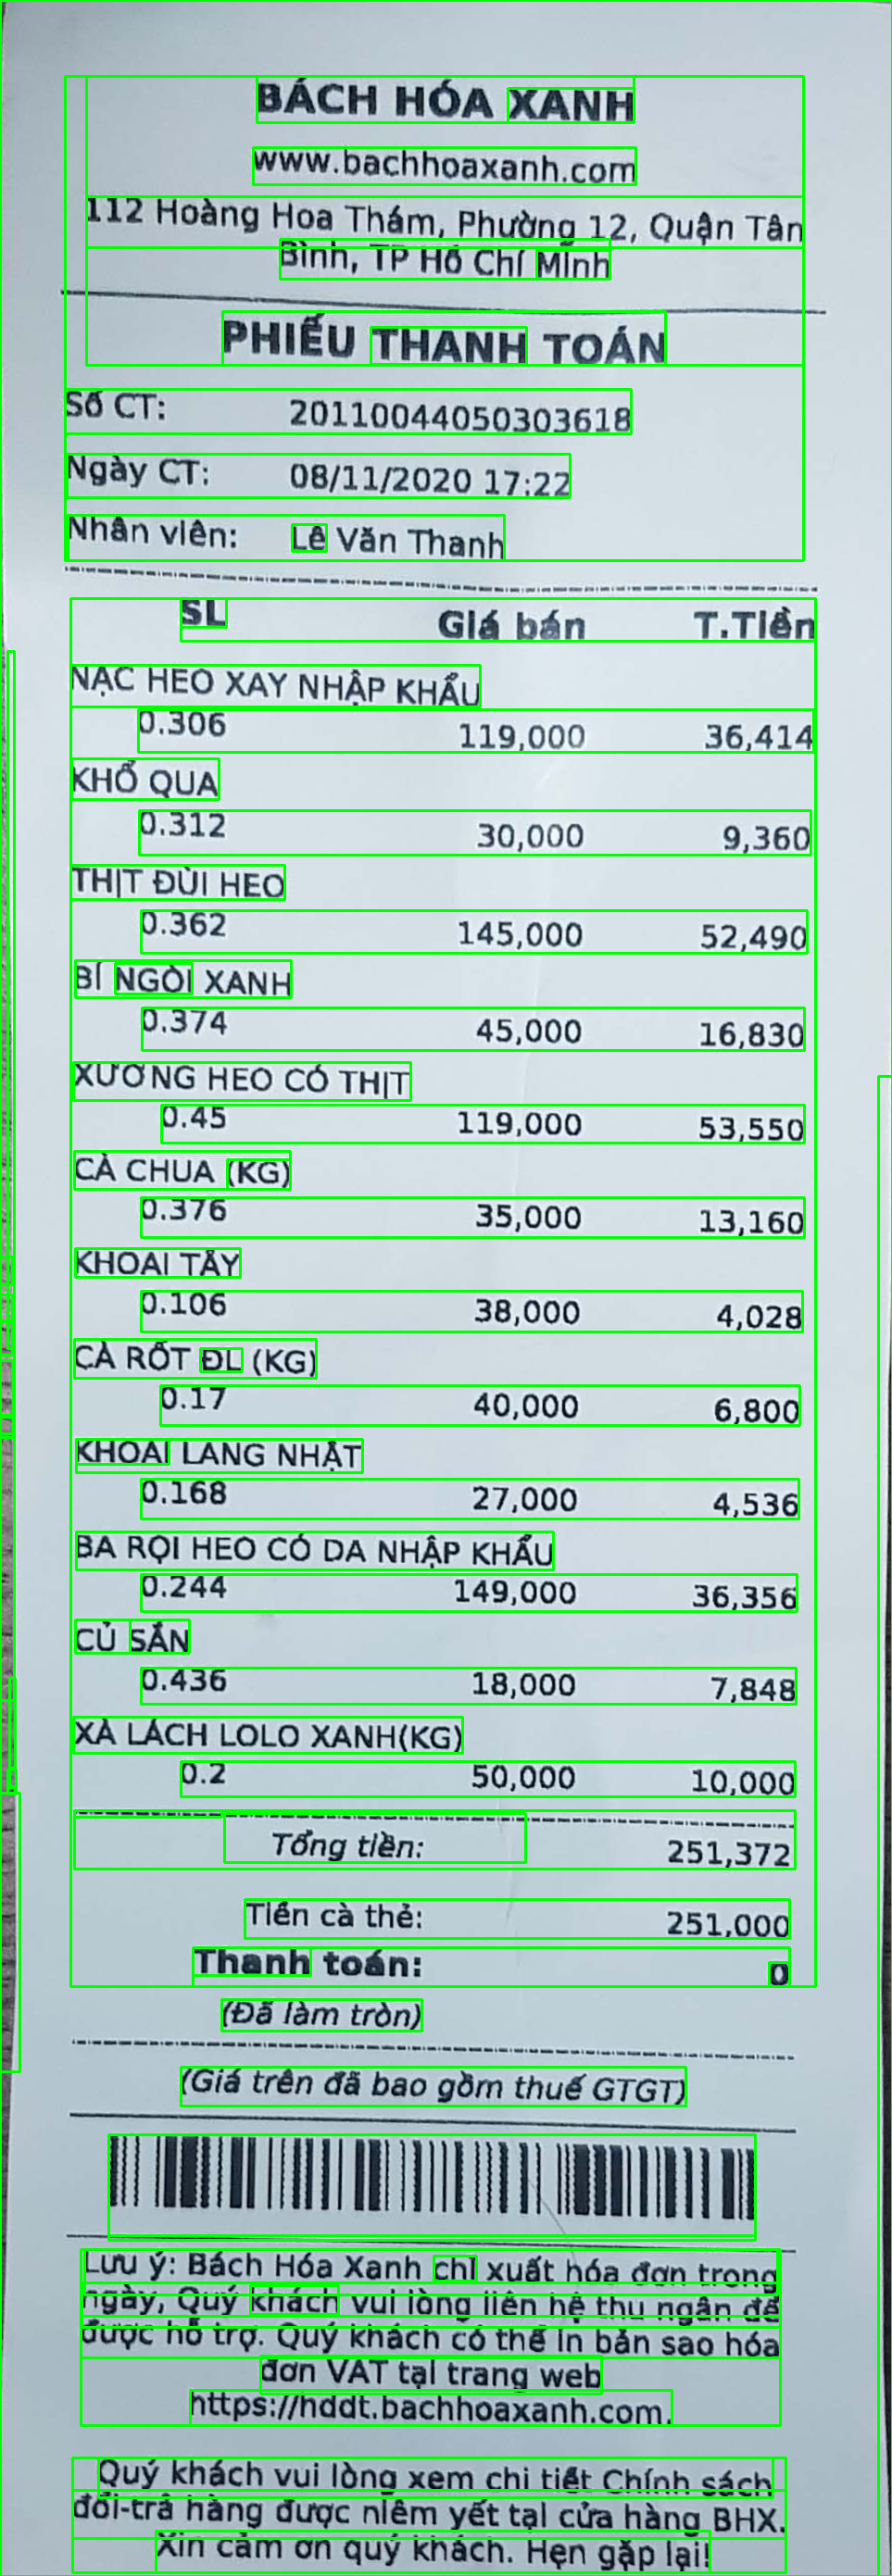

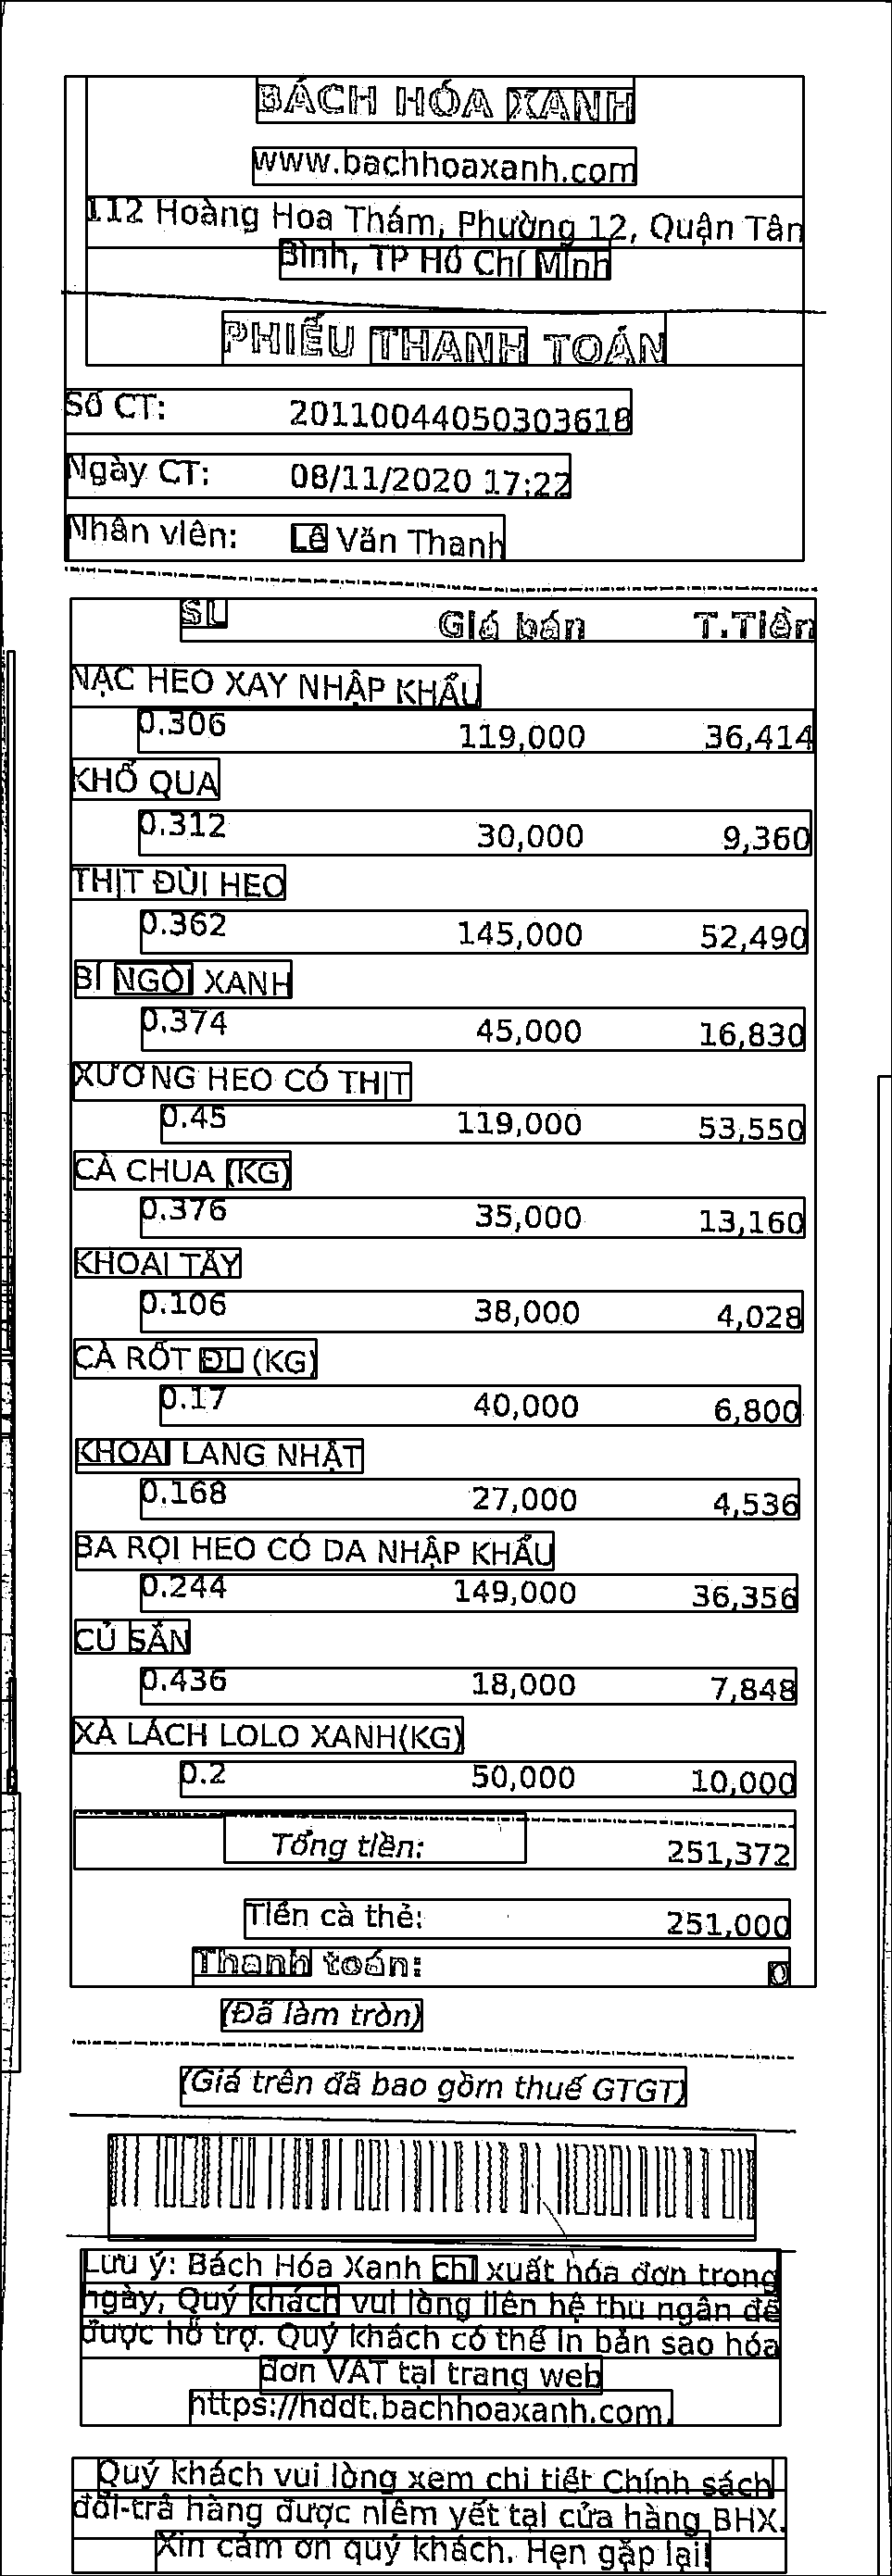

In [ ]:
originalOverlay, imageBox, data = imageToData(originalWarped, warped)
print(data['text'])
cv2_imshow(originalOverlay)
cv2_imshow(imageBox)

In [ ]:
print(imageToString(scanImage)['text'])